In [1]:
from utils.painter import visualize_common_features_samples, visualize_common_features_features, get_feature_list

import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import tqdm
from joblib import load,dump
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none'
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from umap import UMAP
from sklearn.decomposition import PCA
np.random.seed(888)


/mnt/lsl/anaconda3/envs/lungcancer/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load your data
df_mb = pd.read_csv('data_example/clr.csv',index_col=0) # microbiome relative abundance should be processed by Centered log-ratio transformation
df_mt = pd.read_csv('data_example/metabolites.csv',index_col=0)
common_features = load('results/common_features.class')
tax = pd.read_csv('data_example/taxonomy.csv')

In [3]:
colors = ['#6B98C4','#FFBC80','#F5867F']

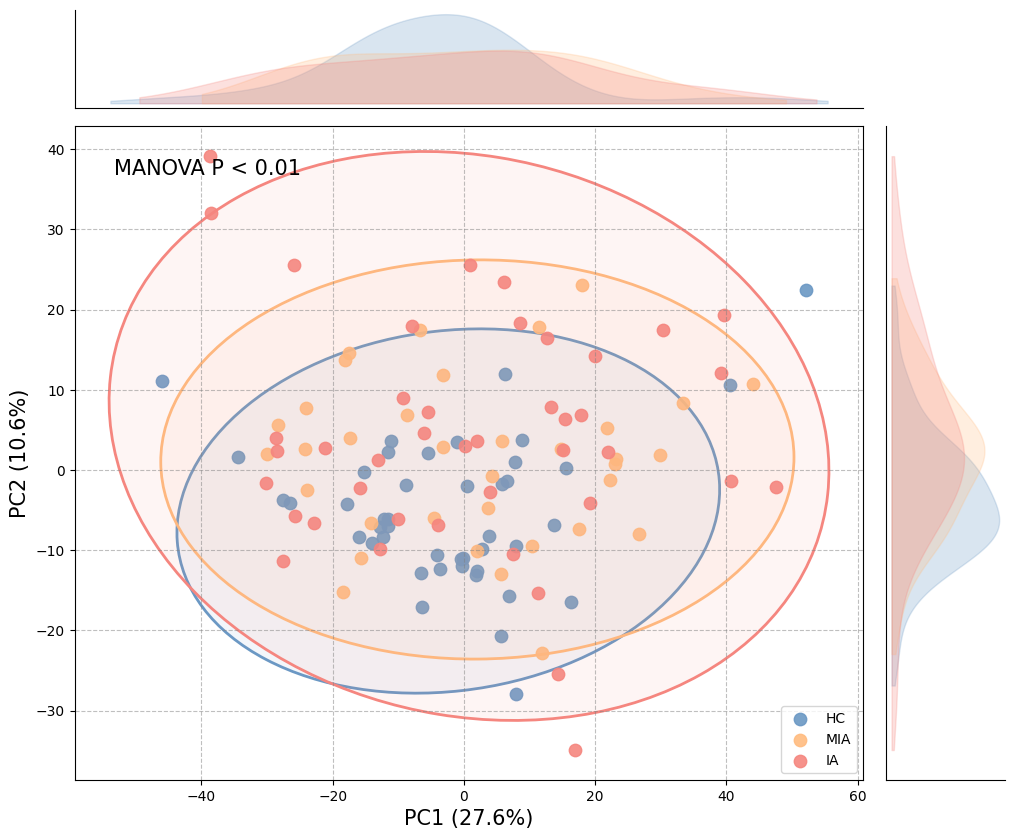

In [4]:
# visualization of samples by spotlight microbes 
visualize_common_features_samples(df_mb, 
                                 common_features=common_features, 
                                 feature_type='microbe', 
                                 group=['HC', 'MIA', 'IA'], 
                                 method='PCA', 
                                 colors=colors, 
                                 use_all_features=False,)

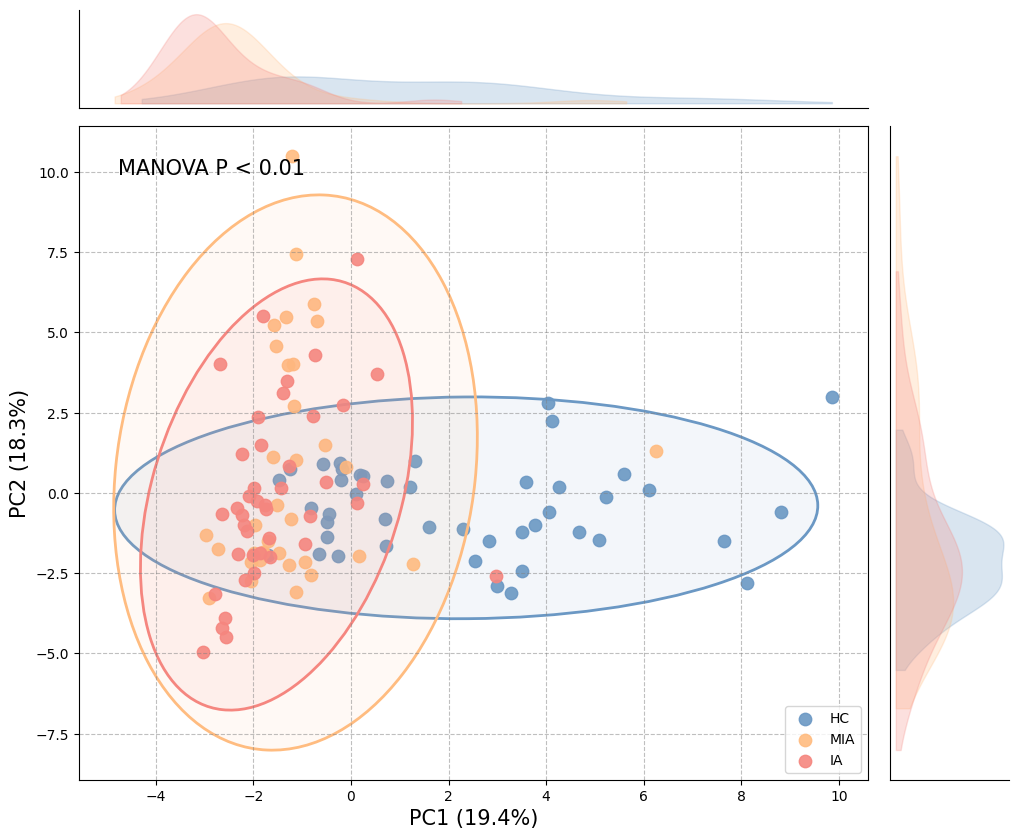

In [5]:
# visualization of samples by spotlight metabolites 
visualize_common_features_samples(df_mt, 
                                 common_features=common_features, 
                                 feature_type='metabolite', 
                                 group=['HC', 'MIA', 'IA'], 
                                 method='PCA', 
                                 colors=colors, 
                                 use_all_features=False,)

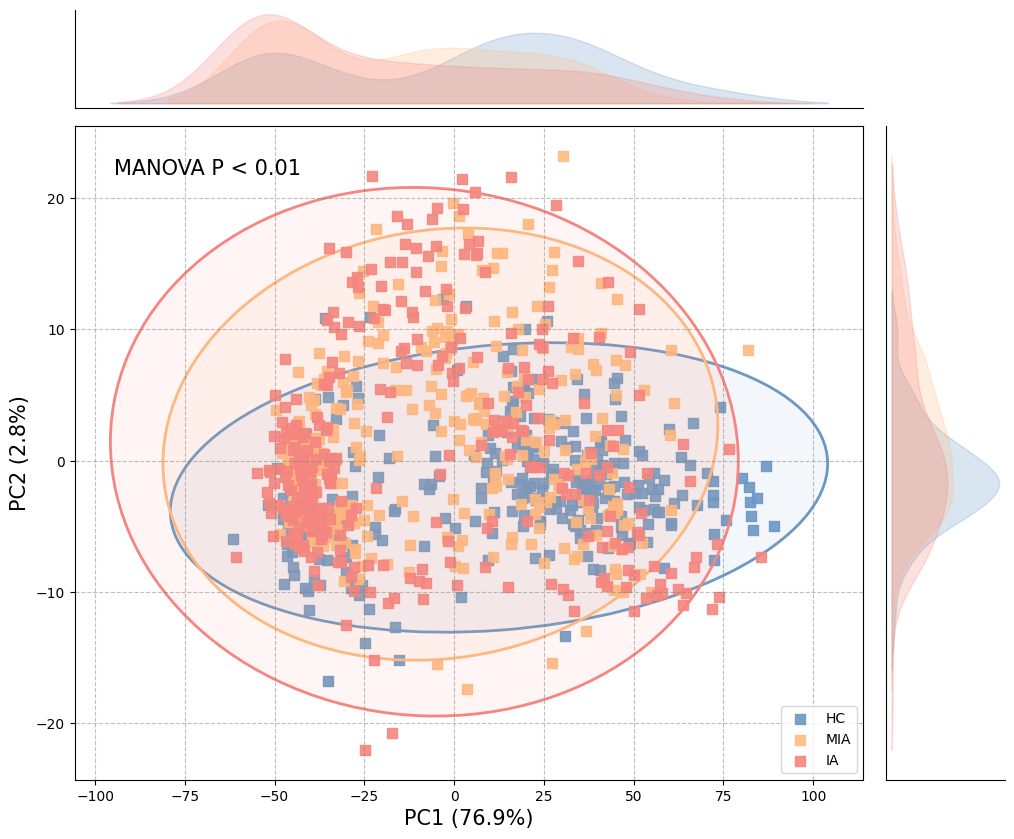

In [6]:
# visualization of spotlight microbes
visualize_common_features_features(df_mb, df_mt,
                                 common_features=common_features, 
                                   data_type='microbe',
                                 method='PCA', 
                                 colors=colors,  )

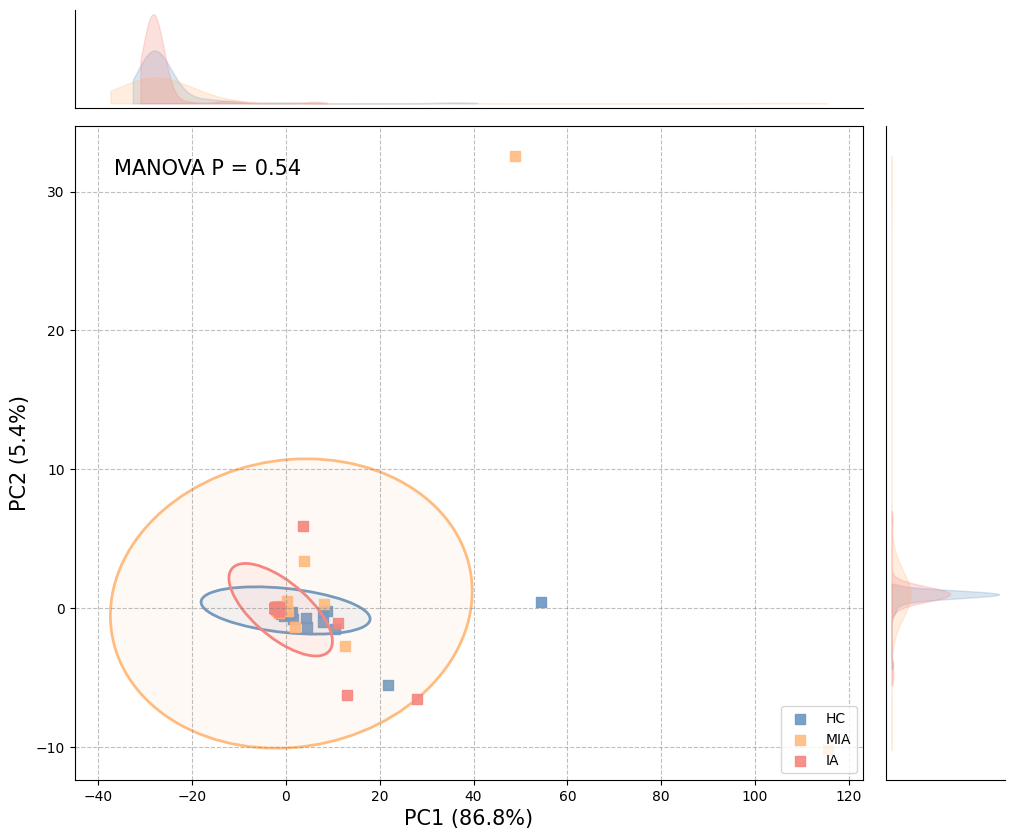

In [7]:
# visualization of spotlight metabolites
visualize_common_features_features(df_mb, df_mt,
                                 common_features=common_features, 
                                   data_type='metabolite',
                                 method='PCA', 
                                 colors=colors,  )

In [8]:
# dynamic evolution of HC core microbial community, data preperation



common_microbes = get_feature_list('HC','microbe',common_features, mode = 'unique_to_each')
common_microbes = [m for m in common_microbes if m in df_mb.columns]
df_mb_common = df_mb[common_microbes]
df_mb_mix_hc = df_mb_common.T['HC']
df_mb_mix_hc.index = [i+'_HC' for i in df_mb_mix_hc.index]
df_mb_mix_mia = df_mb_common.T['MIA']
df_mb_mix_mia.index = [i+'_MIA' for i in df_mb_mix_mia.index]
df_mb_mix_ia = df_mb_common.T['IA']
df_mb_mix_ia.index = [i+'_IA' for i in df_mb_mix_ia.index]
D_mb_hc = squareform(pdist(df_mb_mix_hc, metric='correlation'))  
D_mb_mia = squareform(pdist(df_mb_mix_mia, metric='correlation'))  
D_mb_ia = squareform(pdist(df_mb_mix_ia, metric='correlation'))  
D_mb_all = pd.DataFrame(np.concatenate([D_mb_hc,D_mb_mia,D_mb_ia]))
D_mb_all.index = np.concatenate([['HC']*len(df_mb_mix_hc),['MIA']*len(df_mb_mix_mia),['IA']*len(df_mb_mix_ia)])

Number of families displayed: 11


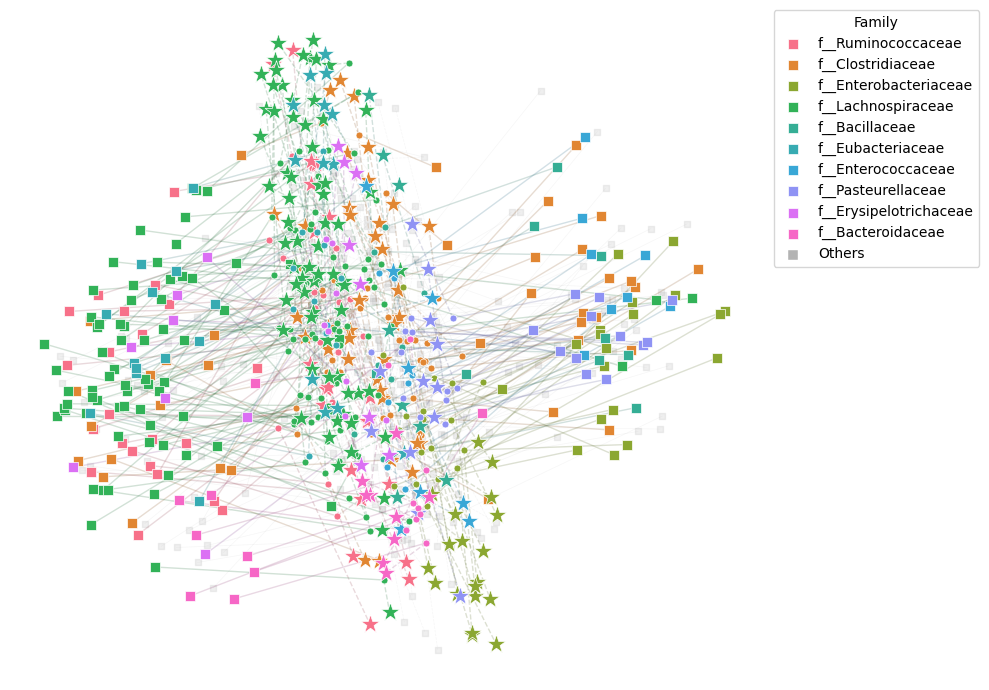

In [9]:
# dynamic evolution of HC core microbial community, PCA

# Step 1: Build data
X = np.concatenate([D_mb_hc, D_mb_mia, D_mb_ia])
labels = np.concatenate([df_mb_mix_hc.index, df_mb_mix_mia.index, df_mb_mix_ia.index])

# PCA
reducer = PCA(n_components=2, random_state=42)
X_emb = reducer.fit_transform(X)

# UMAP
# reducer = UMAP(n_components=2, random_state=42, n_neighbors=5, min_dist=0.5)
# X_emb = reducer.fit_transform(X)

# Construct DataFrame
df_vis = pd.DataFrame(X_emb, columns=['PC1', 'PC2'])
df_vis['label'] = labels
df_vis['bug'] = df_vis['label'].str.replace(r'_(HC|MIA|IA)$', '', regex=True)
df_vis['group'] = df_vis['label'].str.extract(r'_(HC|MIA|IA)$')[0]

# Step 2: Extract families and filter major ones
def extract_family(tax_str):
    if pd.isna(tax_str):
        return 'Unclassified'
    parts = tax_str.split(';')
    for p in parts:
        if p.startswith('f__'):
            return p
    return 'Unclassified'

tax['family'] = tax['Taxonomy'].map(extract_family)
bug_to_family = dict(zip(tax['ID'], tax['family']))
df_vis['family'] = df_vis['bug'].map(bug_to_family).fillna('Unclassified')

# Keep only families with >=20 samples, others → "Others"
family_counts = df_vis['family'].value_counts()
major_families = family_counts[family_counts >= 20].index.tolist()
df_vis['family_grouped'] = df_vis['family'].apply(
    lambda x: x if (x in major_families and 
                   x not in ['Unclassified', 'f__Unclassified']) 
             else 'Others'
)

unique_families = df_vis['family_grouped'].unique()
print(f"Number of families displayed: {len(unique_families)}")

# Step 3: Assign colors
def generate_distinct_colors(n):
    if n <= 10:
        palette = sns.color_palette("Set2", n_colors=min(n, 8))
        if n > 8:
            extra_palette = sns.color_palette("pastel", n_colors=n-8)
            palette.extend(extra_palette)
        return palette
    else:
        return sns.color_palette("husl", n_colors=n)

palette = generate_distinct_colors(len(unique_families))
family_to_color = {fam: palette[i] for i, fam in enumerate(unique_families)}

# Force "Others" to gray
if 'Others' in family_to_color:
    family_to_color['Others'] = (0.7, 0.7, 0.7)

def darken(rgb, factor=0.6):
    return tuple(factor * c for c in rgb)

# Step 4: Cohort parameters
group_order = ['HC', 'MIA', 'IA']

group_style = {
    'HC': {'marker': 's', 'alpha': 1, 'size': 60},
    'MIA': {'marker': '.', 'alpha': 1, 'size': 100},
    'IA': {'marker': '*', 'alpha': 1, 'size': 200}
}

line_style = {
    'HC-MIA': {'linestyle': '-', 'alpha': 0.2, 'linewidth': 1},
    'MIA-IA': {'linestyle': '--', 'alpha': 0.2, 'linewidth': 1}
}

# Step 5: Plot
plt.figure(figsize=(10, 7))

# Draw "Others" first (background gray)
if 'Others' in unique_families:
    others_df = df_vis[df_vis['family_grouped'] == 'Others']
    color_rgb = family_to_color['Others']
    darker = darken(color_rgb, 0.6)
    
    for bug, bug_df in others_df.groupby('bug'):
        if bug_df.shape[0] >= 2:
            bug_df = bug_df.set_index('group').loc[
                [g for g in group_order if g in bug_df['group'].values]
            ].reset_index()
            for i in range(len(bug_df) - 1):
                start_group = bug_df.iloc[i]['group']
                end_group = bug_df.iloc[i+1]['group']
                segment_key = f"{start_group}-{end_group}"
                if segment_key in line_style:
                    style = line_style[segment_key]
                    plt.plot([bug_df.iloc[i]['PC1'], bug_df.iloc[i+1]['PC1']], 
                             [bug_df.iloc[i]['PC2'], bug_df.iloc[i+1]['PC2']], 
                             color=darker,
                             linestyle=style['linestyle'],
                             alpha=style['alpha'] * 0.3,
                             linewidth=style['linewidth'] * 0.5,
                             zorder=1)
    
    plt.scatter(others_df['PC1'], others_df['PC2'], color=[color_rgb], 
                s=25, alpha=0.2, label='Others', zorder=2, marker='s')

# Draw major families (foreground, colorful)
legend_handles = []
legend_labels = []

for family in [f for f in unique_families if f != 'Others']:
    fam_df = df_vis[df_vis['family_grouped'] == family]
    color_rgb = family_to_color[family]
    darker = darken(color_rgb, 0.6)

    for bug, bug_df in fam_df.groupby('bug'):
        if bug_df.shape[0] >= 2:
            bug_df = bug_df.set_index('group').loc[
                [g for g in group_order if g in bug_df['group'].values]
            ].reset_index()
            for i in range(len(bug_df) - 1):
                start_group = bug_df.iloc[i]['group']
                end_group = bug_df.iloc[i+1]['group']
                segment_key = f"{start_group}-{end_group}"
                if segment_key in line_style:
                    style = line_style[segment_key]
                    plt.plot([bug_df.iloc[i]['PC1'], bug_df.iloc[i+1]['PC1']], 
                             [bug_df.iloc[i]['PC2'], bug_df.iloc[i+1]['PC2']], 
                             color=darker,
                             linestyle=style['linestyle'],
                             alpha=style['alpha'],
                             linewidth=style['linewidth'],
                             zorder=3)

    for group in group_order:
        group_data = fam_df[fam_df['group'] == group]
        if len(group_data) > 0:
            scatter = plt.scatter(group_data['PC1'], group_data['PC2'], 
                                  color=[color_rgb],
                                  s=group_style[group]['size'], 
                                  alpha=group_style[group]['alpha'], 
                                  marker=group_style[group]['marker'], 
                                  zorder=4, edgecolors='white', linewidth=0.5)
            if group == group_order[0]:
                legend_handles.append(scatter)
                legend_labels.append(family)

# Add "Others" to legend
if 'Others' in unique_families:
    others_scatter = plt.scatter([], [], color=[family_to_color['Others']], 
                                 s=group_style['HC']['size'], 
                                 alpha=group_style['HC']['alpha'], 
                                 marker=group_style['HC']['marker'],
                                 edgecolors='white', linewidth=0.3)
    legend_handles.append(others_scatter)
    legend_labels.append('Others')

# Step 6: Beautify
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.legend(legend_handles, legend_labels, 
           title='Family', bbox_to_anchor=(1.02, 1), loc='upper left', 
           borderaxespad=0., fontsize=10)

plt.grid(False)
plt.tight_layout()
plt.show()

Number of families displayed: 11


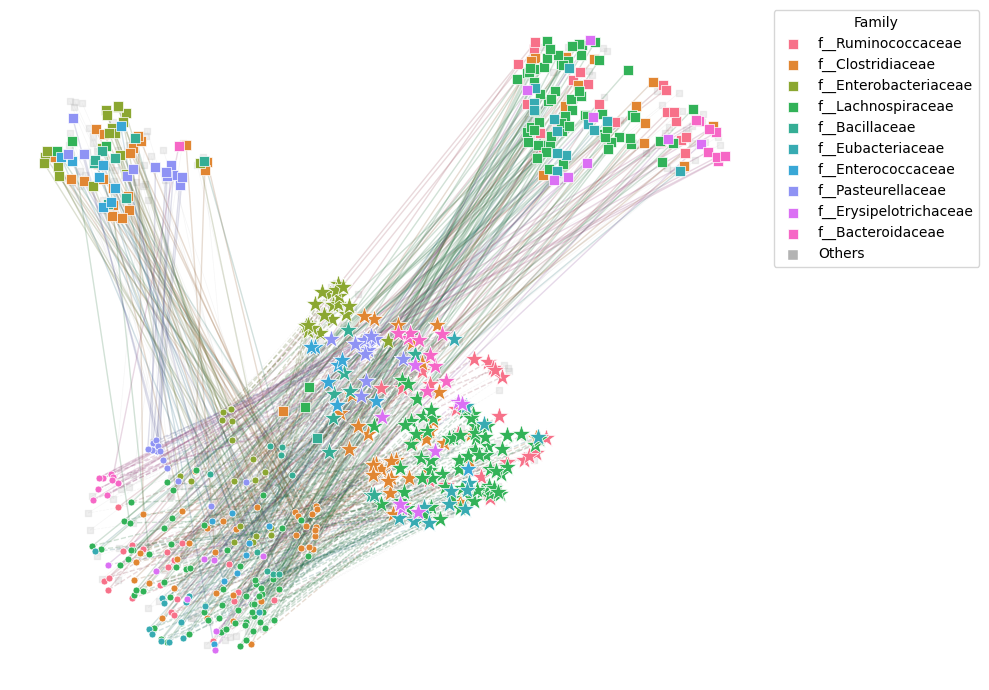

In [10]:
# dynamic evolution of HC core microbial community, UMAP

# Step 1: Build data
X = np.concatenate([D_mb_hc, D_mb_mia, D_mb_ia])
labels = np.concatenate([df_mb_mix_hc.index, df_mb_mix_mia.index, df_mb_mix_ia.index])

# PCA
# reducer = PCA(n_components=2, random_state=42)
# X_emb = reducer.fit_transform(X)

# UMAP
reducer = UMAP(n_components=2, random_state=42, n_neighbors=5, min_dist=0.5)
X_emb = reducer.fit_transform(X)

# Construct DataFrame
df_vis = pd.DataFrame(X_emb, columns=['PC1', 'PC2'])
df_vis['label'] = labels
df_vis['bug'] = df_vis['label'].str.replace(r'_(HC|MIA|IA)$', '', regex=True)
df_vis['group'] = df_vis['label'].str.extract(r'_(HC|MIA|IA)$')[0]

# Step 2: Extract families and filter major ones
def extract_family(tax_str):
    if pd.isna(tax_str):
        return 'Unclassified'
    parts = tax_str.split(';')
    for p in parts:
        if p.startswith('f__'):
            return p
    return 'Unclassified'

tax['family'] = tax['Taxonomy'].map(extract_family)
bug_to_family = dict(zip(tax['ID'], tax['family']))
df_vis['family'] = df_vis['bug'].map(bug_to_family).fillna('Unclassified')

# Keep only families with >=20 samples, others → "Others"
family_counts = df_vis['family'].value_counts()
major_families = family_counts[family_counts >= 20].index.tolist()
df_vis['family_grouped'] = df_vis['family'].apply(
    lambda x: x if (x in major_families and 
                   x not in ['Unclassified', 'f__Unclassified']) 
             else 'Others'
)

unique_families = df_vis['family_grouped'].unique()
print(f"Number of families displayed: {len(unique_families)}")

# Step 3: Assign colors
def generate_distinct_colors(n):
    if n <= 10:
        palette = sns.color_palette("Set2", n_colors=min(n, 8))
        if n > 8:
            extra_palette = sns.color_palette("pastel", n_colors=n-8)
            palette.extend(extra_palette)
        return palette
    else:
        return sns.color_palette("husl", n_colors=n)

palette = generate_distinct_colors(len(unique_families))
family_to_color = {fam: palette[i] for i, fam in enumerate(unique_families)}

# Force "Others" to gray
if 'Others' in family_to_color:
    family_to_color['Others'] = (0.7, 0.7, 0.7)

def darken(rgb, factor=0.6):
    return tuple(factor * c for c in rgb)

# Step 4: Cohort parameters
group_order = ['HC', 'MIA', 'IA']

group_style = {
    'HC': {'marker': 's', 'alpha': 1, 'size': 60},
    'MIA': {'marker': '.', 'alpha': 1, 'size': 100},
    'IA': {'marker': '*', 'alpha': 1, 'size': 200}
}

line_style = {
    'HC-MIA': {'linestyle': '-', 'alpha': 0.2, 'linewidth': 1},
    'MIA-IA': {'linestyle': '--', 'alpha': 0.2, 'linewidth': 1}
}

# Step 5: Plot
plt.figure(figsize=(10, 7))

# Draw "Others" first (background gray)
if 'Others' in unique_families:
    others_df = df_vis[df_vis['family_grouped'] == 'Others']
    color_rgb = family_to_color['Others']
    darker = darken(color_rgb, 0.6)
    
    for bug, bug_df in others_df.groupby('bug'):
        if bug_df.shape[0] >= 2:
            bug_df = bug_df.set_index('group').loc[
                [g for g in group_order if g in bug_df['group'].values]
            ].reset_index()
            for i in range(len(bug_df) - 1):
                start_group = bug_df.iloc[i]['group']
                end_group = bug_df.iloc[i+1]['group']
                segment_key = f"{start_group}-{end_group}"
                if segment_key in line_style:
                    style = line_style[segment_key]
                    plt.plot([bug_df.iloc[i]['PC1'], bug_df.iloc[i+1]['PC1']], 
                             [bug_df.iloc[i]['PC2'], bug_df.iloc[i+1]['PC2']], 
                             color=darker,
                             linestyle=style['linestyle'],
                             alpha=style['alpha'] * 0.3,
                             linewidth=style['linewidth'] * 0.5,
                             zorder=1)
    
    plt.scatter(others_df['PC1'], others_df['PC2'], color=[color_rgb], 
                s=25, alpha=0.2, label='Others', zorder=2, marker='s')

# Draw major families (foreground, colorful)
legend_handles = []
legend_labels = []

for family in [f for f in unique_families if f != 'Others']:
    fam_df = df_vis[df_vis['family_grouped'] == family]
    color_rgb = family_to_color[family]
    darker = darken(color_rgb, 0.6)

    for bug, bug_df in fam_df.groupby('bug'):
        if bug_df.shape[0] >= 2:
            bug_df = bug_df.set_index('group').loc[
                [g for g in group_order if g in bug_df['group'].values]
            ].reset_index()
            for i in range(len(bug_df) - 1):
                start_group = bug_df.iloc[i]['group']
                end_group = bug_df.iloc[i+1]['group']
                segment_key = f"{start_group}-{end_group}"
                if segment_key in line_style:
                    style = line_style[segment_key]
                    plt.plot([bug_df.iloc[i]['PC1'], bug_df.iloc[i+1]['PC1']], 
                             [bug_df.iloc[i]['PC2'], bug_df.iloc[i+1]['PC2']], 
                             color=darker,
                             linestyle=style['linestyle'],
                             alpha=style['alpha'],
                             linewidth=style['linewidth'],
                             zorder=3)

    for group in group_order:
        group_data = fam_df[fam_df['group'] == group]
        if len(group_data) > 0:
            scatter = plt.scatter(group_data['PC1'], group_data['PC2'], 
                                  color=[color_rgb],
                                  s=group_style[group]['size'], 
                                  alpha=group_style[group]['alpha'], 
                                  marker=group_style[group]['marker'], 
                                  zorder=4, edgecolors='white', linewidth=0.5)
            if group == group_order[0]:
                legend_handles.append(scatter)
                legend_labels.append(family)

# Add "Others" to legend
if 'Others' in unique_families:
    others_scatter = plt.scatter([], [], color=[family_to_color['Others']], 
                                 s=group_style['HC']['size'], 
                                 alpha=group_style['HC']['alpha'], 
                                 marker=group_style['HC']['marker'],
                                 edgecolors='white', linewidth=0.3)
    legend_handles.append(others_scatter)
    legend_labels.append('Others')

# Step 6: Beautify
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.legend(legend_handles, legend_labels, 
           title='Family', bbox_to_anchor=(1.02, 1), loc='upper left', 
           borderaxespad=0., fontsize=10)

plt.grid(False)
plt.tight_layout()
plt.show()